In [1]:
from test_hybrid import (
    block_integral_curvatures_cpp,
    get_dist_mat_hybrid,
    homog_aug
)

In [2]:
import numpy as np
import cPickle as pickle
from os.path import join

with open("../dataset_loc", 'r') as f:
    dataset_loc = f.read().rstrip()

with open(join(dataset_loc, "Flukes/zooniverse_curvatures_winteg.pkl"), 'r') as f:
    curvatures = pickle.load(f)

img_points_map = {}
with open(join(dataset_loc, "Flukes/extracted_zsl_annotations.pkl"), 'r') as f:
    annot = pickle.load(f)
    for id_ in annot:
        for desc in annot[id_]:
            img_points_map[desc['fn']] = np.array([desc['left'], desc['right'], desc['notch']], dtype=np.float32)

In [3]:
import utool as ut
import random
import cv2

def hybrid_dist(c1, c2, compare_on=None, window=50, sizes=[5,10,15,20], alpha=0.5, weights=None):
    # align first
    if weights is None:
        weights = {size:1. for size in sizes}
    transform = cv2.getAffineTransform(img_points_map[c2['fn']], img_points_map[c1['fn']])
    aligned_c2 = np.ascontiguousarray(np.dot(transform, homog_aug(np.array(c2['path'])).T).T.astype(np.int32))
    # then get curvatures
    curv1 = block_integral_curvatures_cpp(sizes, c1['path'])
    curv2 = block_integral_curvatures_cpp(sizes, aligned_c2)
    # then get distance
    dist_mat = get_dist_mat_hybrid(c1['path'], curv1, aligned_c2, curv2,
                                   weights, alpha, window=window)
    # we want to save the aligned path, and the full distance matrix as well
    return dist_mat[-1,-1], {'distmat':dist_mat, 'transform':transform,
                             'c1curv':curv1, 'c2curv':curv2}

def triplet_eval_hybrid_qual(curvatures, dist_method, compare_on, n_triplets=200, verbose=False):
    id_curv_map = {}
    for curv in curvatures:
        if curv['id'] in id_curv_map:
            id_curv_map[curv['id']].append(curv)
        else:
            id_curv_map[curv['id']] = [curv]
    #print(len(id_curv_map))
    good_count = 0
    triplet_infos = []
    # for complete coverage we'll generate a triplet for at most each id
    idlist = filter(lambda x: len(id_curv_map[x]) > 1, id_curv_map.keys())
    for _ in ut.ProgressIter(range(n_triplets), label='triplet', enabled=verbose):
        anchor = random.choice(idlist)
        random.shuffle(id_curv_map[anchor])
        negative = random.choice(filter(lambda x: x != anchor, idlist))
        random.shuffle(id_curv_map[negative])
        anchor_pos_dist, anchor_pos_info = dist_method(id_curv_map[anchor][0], id_curv_map[anchor][1],
                                     compare_on=compare_on)
        anchor_neg_dist, anchor_neg_info = dist_method(id_curv_map[anchor][0], id_curv_map[negative][0],
                                     compare_on=compare_on)
        triplet_info = {
            'anchor_fn':id_curv_map[anchor][0]['fn'],
            'pos_fn':id_curv_map[anchor][1]['fn'],
            'neg_fn':id_curv_map[negative][0]['fn'],
            'pos_transform':anchor_pos_info['transform'],
            'neg_transform':anchor_neg_info['transform'],
            'anchor_path':id_curv_map[anchor][0]['path'],
            'pos_path':id_curv_map[anchor][1]['path'],
            'neg_path':id_curv_map[negative][0]['path'],
            'anchor_curv':anchor_pos_info['c1curv'],
            'pos_curv':anchor_pos_info['c2curv'], # note this is curvature of aligned
            'neg_curv':anchor_neg_info['c2curv'],
            'anchor_pos_dist':anchor_pos_dist,
            'anchor_neg_dist':anchor_neg_dist,
            'pos_id':anchor,
            'neg_id':negative,
        }
        triplet_infos.append(triplet_info)
        #print("Distance between two instances of %s: %0.2f" % (anchor, anchor_pos_dist))
        #print("Distance between %s and %s: %0.2f" % (anchor, negative, anchor_neg_dist))
        if anchor_pos_dist < anchor_neg_dist:
            good_count += 1

    return (good_count / float(n_triplets)), triplet_infos



In [65]:
from functools import partial

score, triplet_eval_1k = triplet_eval_hybrid_qual(curvatures, 
                                      partial(hybrid_dist, alpha=0.67, window=40), 
                                      'path', n_triplets=1000, verbose=False)
print(score)

0.718


In [66]:
score, triplet_eval_1k_allcurv = triplet_eval_hybrid_qual(curvatures, 
                                      partial(hybrid_dist, alpha=0, window=40), 
                                      'path', n_triplets=1000, verbose=False)
print(score)

0.635


In [68]:
imgs_dir = join(dataset_loc, "Flukes/CRC_combined constrained")

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import cosine
import plottool
import vtool

def visualize_paths(path1, path2):
    p1 = np.array(path1)
    p2 = np.array(path2)
    y_extent = max(np.max(np.abs(p1[:,1])), np.max(np.abs(p2[:,1])))
    x_extent = max(np.max(np.abs(p1[:,0])), np.max(np.abs(p2[:,0])))
    # assume x_extent is 960
    image = np.ones((y_extent+1, x_extent+1, 3), dtype=np.uint8) * 255
    image[y_extent,:,:] = 0
    for point in p1:
        image[point[1],point[0],:] = np.array([255,0,0])
    for point in p2:
        image[point[1],point[0],:] = np.array([0,255,0])
    return image

def visualize_curvature(curv, curv_weights, block_size):
    wmax = max(curv_weights.values())
    image = np.zeros((block_size*len(curv), len(curv[curv.keys()[0]])))
    for vind, size in enumerate(sorted(curv, key=lambda x: -curv_weights[x])):
        this_block_size = int((curv_weights[size] / wmax) * block_size)
        for hind, curv_elt in enumerate(curv[size]):
            image[vind*block_size:(vind*block_size + this_block_size), 
                  hind:(hind+1)] = curv_elt
    print(image.shape)
    return image


affine2homog = lambda x: np.vstack([x, np.array([0,0,1]).reshape(1,-1)])
def visualize_transform(affine_trans):
    #plottool.figure(0)
    #affine_trans[:,-1] = np.array([0.5,0.5])
    kpt = vtool.flatten_invV_mats_to_kpts(affine2homog(affine_trans)[None,:])
    #print(kpt[:,3])
    plottool.show_kpts(kpt, eig=True, rect=True)
    plottool.plt.gca().set_aspect('equal')


def overlay_path_points(img, path, points, transform=None):
    img_copy = img[:]
    # assume path is x, y
    if transform is not None:
        path = np.dot(transform,homog_aug(np.array(path)).T).T.astype(np.int32)
        points = np.dot(transform,homog_aug(np.array(points)).T).T.astype(np.int32)
    for j, i in path:
        if (j >= img_copy.shape[1] or j < 0) or (i >= img_copy.shape[0] or i < 0):
                continue
        cv2.circle(img_copy, (j, i), 2, (255,0,0), thickness=-1)
        #img_copy[i,j] = [255,0,0]
    # assume left right notch in x, y
    colors = [[255,0,0],[0,255,0],[0,0,255]]
    for i, color in zip(points, colors):
        cv2.circle(img_copy, tuple(i), 10, tuple(color), thickness=-1)
    return img_copy
            



def total_skew(afftrans):
    eigen_vals, eigen_vecs = np.linalg.eig(afftrans[:,:2])
    # we know there are two eigen vectors
    return cosine(eigen_vecs[:,0], eigen_vecs[:,1])

def afftrans_ecc(afftrans):
    kpt = vtool.flatten_invV_mats_to_kpts(affine2homog(afftrans)[None,:])
    ecc = vtool.get_kpts_excentricity(kpt)[0]
    return ecc
    """
    eigen_vals, _ = np.linalg.eig(afftrans[:,:2])
    # we know there are 2 eigenvals
    a = max(eigen_vals)
    b = min(eigen_vals)
    return np.sqrt(1 - (b**2 / a**2))
    """
    
def visualize_triplet_images(triplet_info, c=5):
    # print distance, ids
    print("Anchor ID: %s" % triplet_info['pos_id'])
    print("Negative ID: %s" % triplet_info['neg_id'])
    print("Distance between Anchor and Pos: %0.2f" % triplet_info['anchor_pos_dist'])
    print("Distance between Anchor and Neg: %0.2f" % triplet_info['anchor_neg_dist'])
    print("Correct triplet? %r" % (triplet_info['anchor_pos_dist'] < triplet_info['anchor_neg_dist']))
    
    #print("Horizontal skew: anchor: %0.2f" % hskew(img_points_map[triplet_info['anchor_fn']]))
    #print("Horizontal skew: pos: %0.2f" % hskew(img_points_map[triplet_info['pos_fn']]))
    #print("Horizontal skew: neg: %0.2f" % hskew(img_points_map[triplet_info['neg_fn']]))
    visualize_transform(triplet_info['pos_transform'])
    visualize_transform(triplet_info['neg_transform'])
    #print("Skew of transform: Pos->Anchor: %0.2f" % total_skew(triplet_info['pos_transform']))
    #print("Skew of transform: Neg->Anchor: %0.2f" % total_skew(triplet_info['neg_transform']))
    print("Eccentricity of transform: Pos->Anchor: %0.2f" % afftrans_ecc(triplet_info['pos_transform']))
    print("Eccentricity of transform: Neg->Anchor: %0.2f" % afftrans_ecc(triplet_info['neg_transform']))

    # first panel: anchor image, aligned positive image, aligned negative image
    fig1, axes1 = plt.subplots(4,2)
    fig1.set_size_inches(50,50)
    fig1.subplots_adjust(hspace=0.1, wspace=0.1)
    anchor_img = overlay_path_points(cv2.imread(join(imgs_dir, triplet_info['anchor_fn'])),
                                     triplet_info['anchor_path'], img_points_map[triplet_info['anchor_fn']])
    
    pos_img = cv2.imread(join(imgs_dir, triplet_info['pos_fn']))
    print("Pos->Anchor transform:\n%s" % triplet_info['pos_transform'])

    pos_img_warped = cv2.warpAffine(pos_img,triplet_info['pos_transform'], anchor_img.shape[:-1][::-1])

    pos_img = overlay_path_points(pos_img, triplet_info['pos_path'], img_points_map[triplet_info['pos_fn']])
    
    pos_img_warped = overlay_path_points(pos_img_warped, triplet_info['pos_path'], 
                                         img_points_map[triplet_info['pos_fn']], 
                                         transform=triplet_info['pos_transform'])
    
    neg_img = cv2.imread(join(imgs_dir, triplet_info['neg_fn']))
    print("Neg->Anchor transform:\n%s" % triplet_info['neg_transform'])
    neg_img_warped = cv2.warpAffine(neg_img,triplet_info['neg_transform'], anchor_img.shape[:-1][::-1])
    neg_img = overlay_path_points(neg_img, triplet_info['neg_path'], img_points_map[triplet_info['neg_fn']])
    
    
    neg_img_warped = overlay_path_points(neg_img_warped, triplet_info['neg_path'], 
                                         img_points_map[triplet_info['neg_fn']], 
                                         transform=triplet_info['neg_transform'])
    
    axes1[0,0].imshow(anchor_img)
    axes1[0,1].axis('off')
    axes1[1,0].imshow(pos_img)
    axes1[1,1].imshow(pos_img_warped)
    axes1[2,0].imshow(neg_img)
    axes1[2,1].imshow(neg_img_warped)
    # second panel: anchor path with aligned positive overlaid, anchor path with aligned negative overlaid
    axes1[3,0].imshow(visualize_paths(triplet_info['anchor_path'],
                                     np.dot(triplet_info['pos_transform'], 
                                            homog_aug(np.array(triplet_info['pos_path'])).T).T.astype(np.int32)))
    axes1[3,1].imshow(visualize_paths(triplet_info['anchor_path'],
                                     np.dot(triplet_info['neg_transform'], 
                                            homog_aug(np.array(triplet_info['neg_path'])).T).T.astype(np.int32)))
    """
    axes1[2,1].axis('off')
    # third panel: curvature visualizations for each (aligned) path
    # visualizing these is not super trivial, what I'm going to settle on is taking each weight 
    fig2, axes2 = plt.subplots(3,1)
    fig2.set_size_inches(50,50)
    fig2.subplots_adjust(hspace=0, wspace=0)
    axes2[0].imshow(visualize_curvature(triplet_info['anchor_curv'], 
                                         {s:1. for s in triplet_info['anchor_curv']}, c), cmap='Blues')
    axes2[1].imshow(visualize_curvature(triplet_info['pos_curv'], 
                                         {s:1. for s in triplet_info['pos_curv']}, c), cmap='Blues')
    axes2[2].imshow(visualize_curvature(triplet_info['neg_curv'], 
                                         {s:1. for s in triplet_info['neg_curv']}, c), cmap='Blues')
    """

Anchor ID: 12111
Negative ID: 15235
Distance between Anchor and Pos: 96.08
Distance between Anchor and Neg: 407.40
Correct triplet? True
Eccentricity of transform: Pos->Anchor: 0.32
Eccentricity of transform: Neg->Anchor: 0.53
Pos->Anchor transform:
[[  9.99895198e-01   2.28279779e-01  -1.05553250e+01]
 [ -9.21349571e-02   1.15503015e+00   9.69286228e+01]]
Neg->Anchor transform:
[[  9.32174027e-01  -5.40546467e-02   5.04846059e+01]
 [ -1.10506849e-01   1.32619914e+00   1.05363215e+02]]


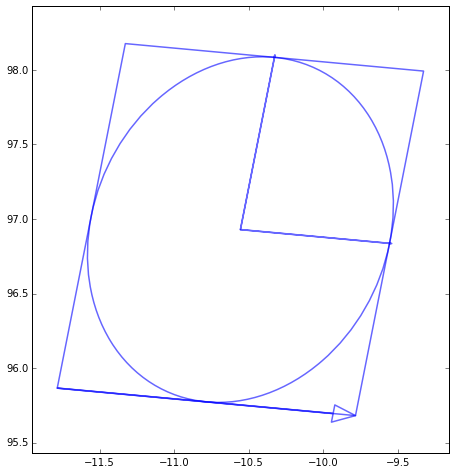

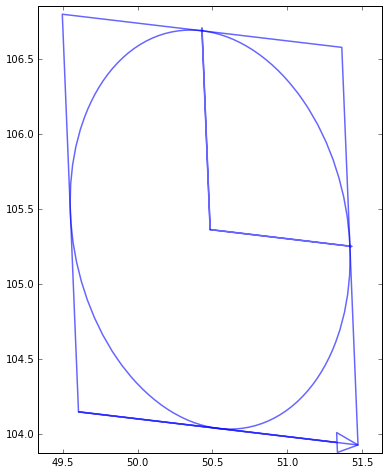

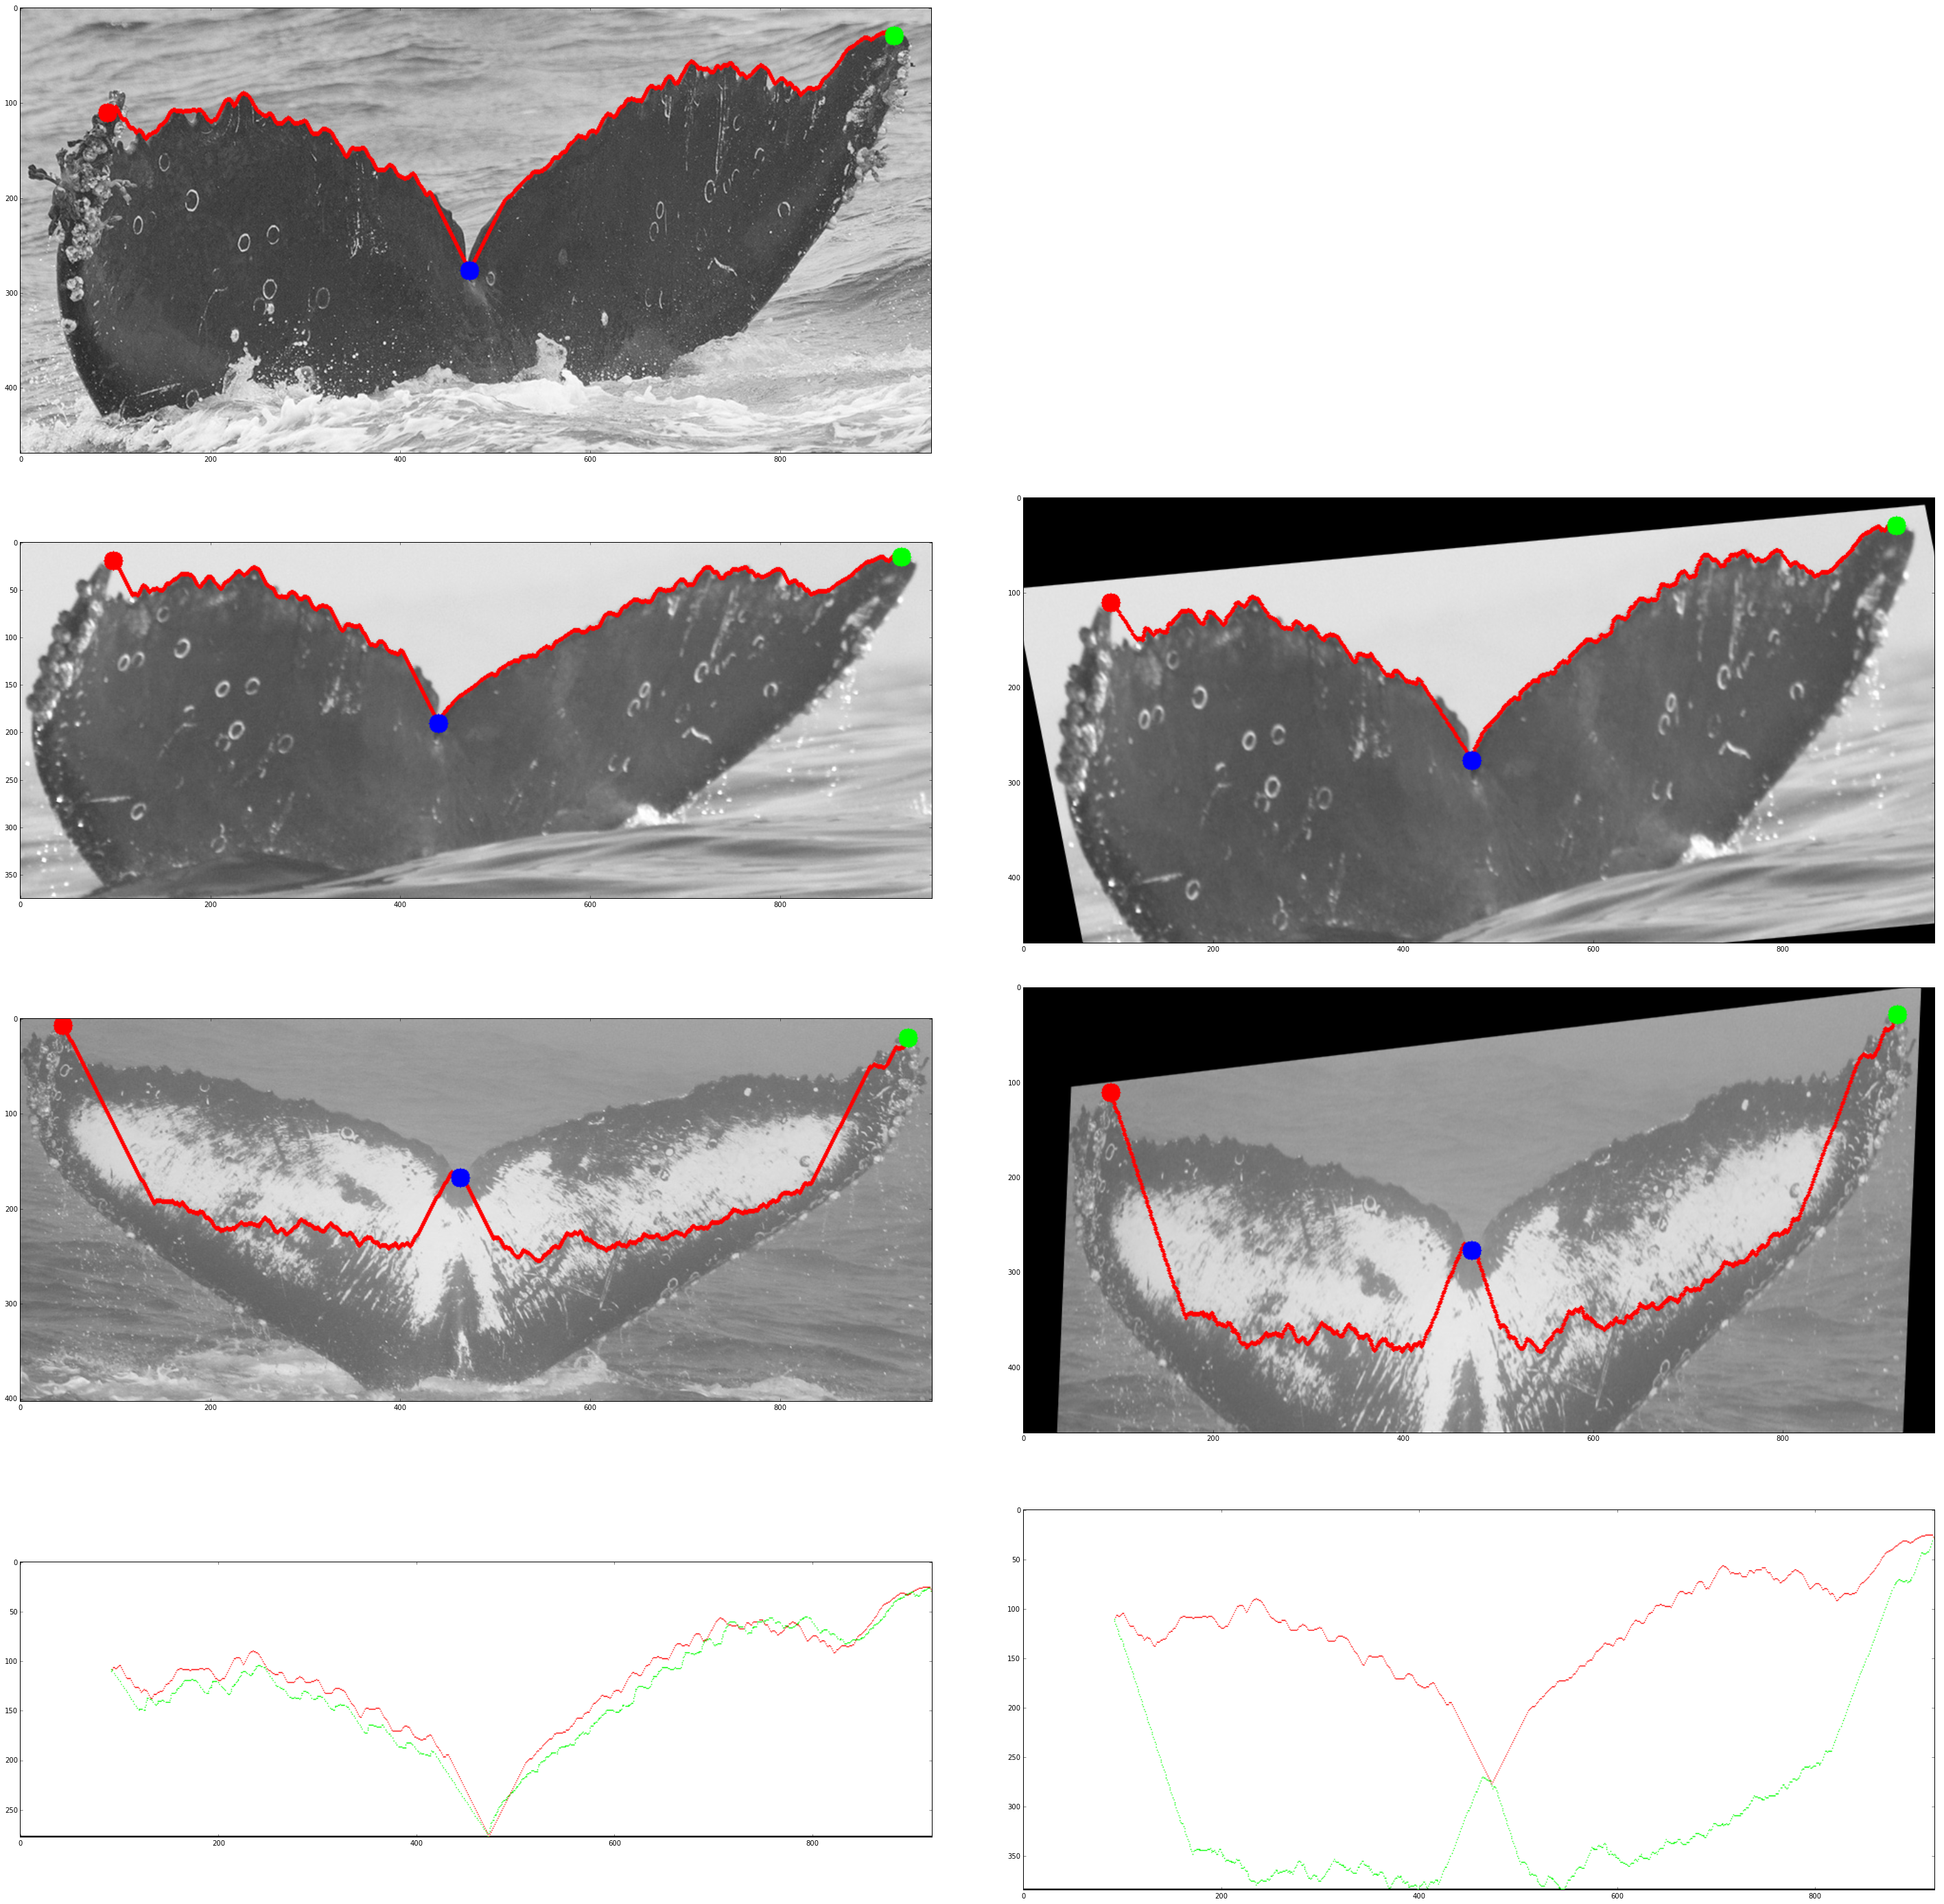

In [74]:
by_worst = sorted(triplet_eval_1k, key=lambda x: x['anchor_neg_dist'] - x['anchor_pos_dist'])
visualize_triplet_images(by_worst[-1], c=10)

Anchor ID: 11411
Negative ID: 11564
Distance between Anchor and Pos: 259.92
Distance between Anchor and Neg: 79.24
Correct triplet? False
Eccentricity of transform: Pos->Anchor: 0.93
Eccentricity of transform: Neg->Anchor: 0.52
Pos->Anchor transform:
[[  1.57940663e+00   1.26720962e-01  -2.66820244e+02]
 [  1.04712042e-02   4.17809358e-01  -3.29872850e+01]]
Neg->Anchor transform:
[[  0.99153381  -0.06587302   2.60848208]
 [  0.02630876   0.6910491  -11.61441275]]


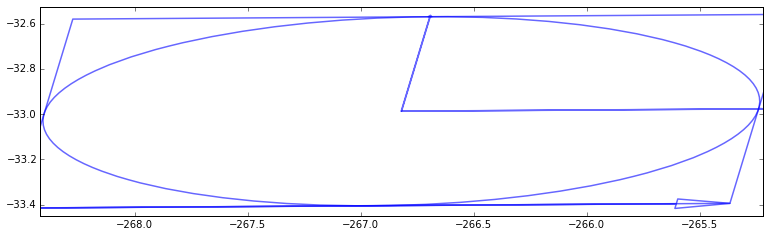

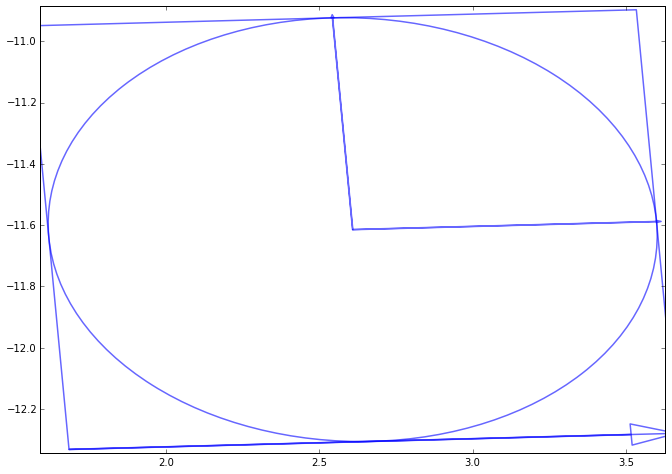

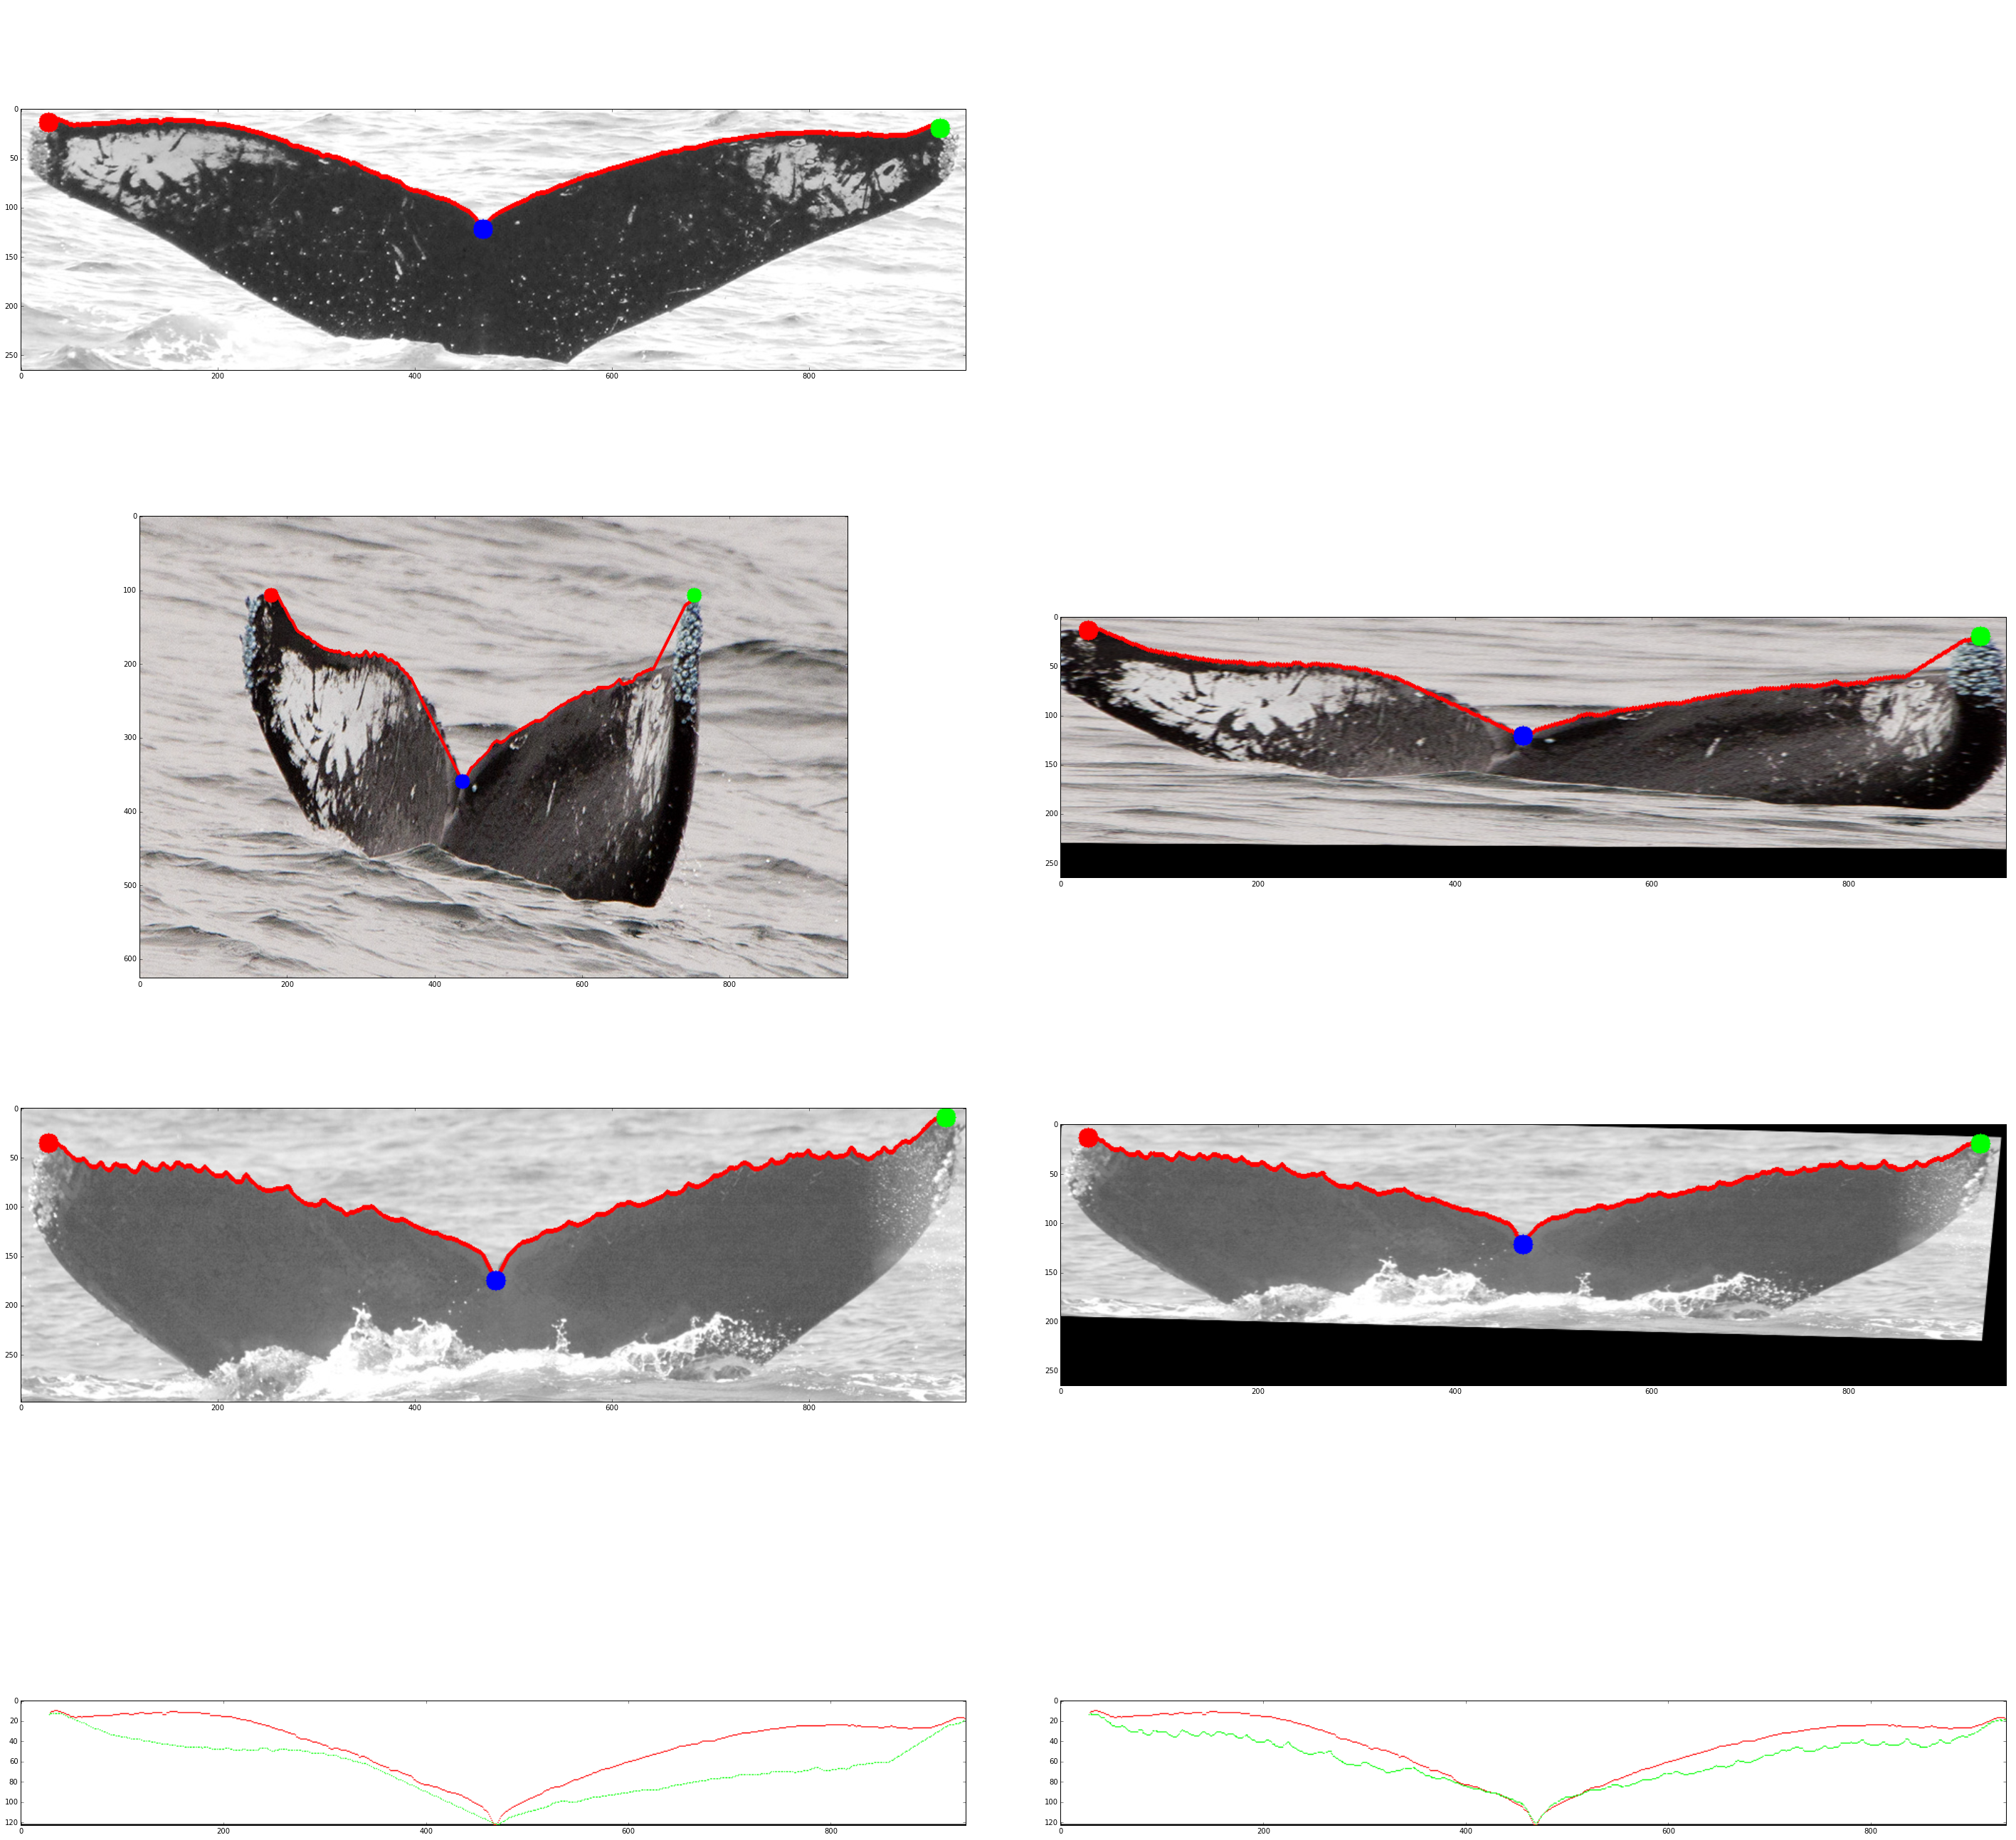

In [88]:
by_worst_curv = sorted(triplet_eval_1k_allcurv, key=lambda x: x['anchor_neg_dist'] - x['anchor_pos_dist'])
visualize_triplet_images(by_worst_curv[0], c=10)

0.418083123119
True


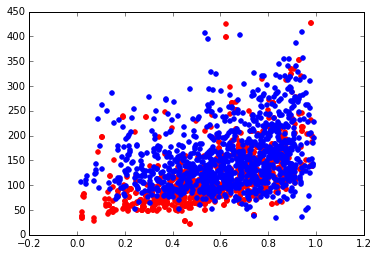

In [99]:
def distance_eccentricity_correlation(triplet_evaluation):
    distances = []
    eccentricities = []
    for triplet_info in triplet_evaluation:
        distances.append(triplet_info['anchor_pos_dist'])
        distances.append(triplet_info['anchor_neg_dist'])
        
        eccentricities.append(afftrans_ecc(triplet_info['pos_transform']))
        eccentricities.append(afftrans_ecc(triplet_info['neg_transform']))
    
    correlation = np.corrcoef(distances, eccentricities)[0,1]
    significance = (correlation*np.sqrt((len(distances)-2) / (1-correlation**2))) > 2
    plt.scatter(eccentricities[::2], distances[::2], color='r') # pos
    plt.scatter(eccentricities[1::2], distances[1::2], color='b') # neg
    print(correlation)
    print(significance)
    
distance_eccentricity_correlation(triplet_eval_1k)


0.595947054718
True


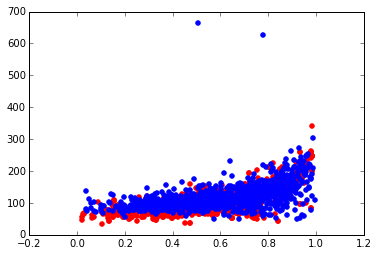

In [100]:
distance_eccentricity_correlation(triplet_eval_1k_allcurv)

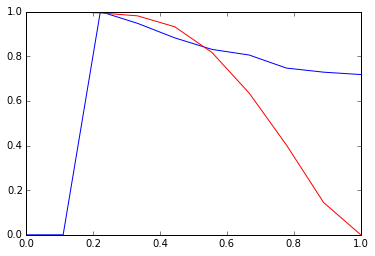

In [85]:
# what's our triplet evaluation look like if we account for bad transformations?
# let's go through the evaluation and ignore those where the eccentricity from pos->anchor exceeds a threshold
def reeval_ecc_thresh(triplet_evaluation, thresh=1):
    good = 0
    bad = 0
    thrown_out = 0
    for triplet_info in triplet_evaluation:
        neg_ecc = afftrans_ecc(triplet_info['neg_transform'])
        pos_ecc = afftrans_ecc(triplet_info['pos_transform'])
        
        if neg_ecc > thresh or pos_ecc > thresh:
            thrown_out += 1
            continue
        elif triplet_info['anchor_pos_dist'] < triplet_info['anchor_neg_dist']:
            good += 1
        else:
            bad += 1
    return (good / float(good + bad + 1e-7)), thrown_out / float(len(triplet_evaluation))

reev_thresh_score, reev_thresh_thrown = zip(*[reeval_ecc_thresh(triplet_eval_1k, thresh) 
                                              for thresh in np.linspace(0,1,10)])
plt.plot(np.linspace(0,1,10), reev_thresh_score, color='b')
plt.plot(np.linspace(0,1,10), reev_thresh_thrown, color='r')

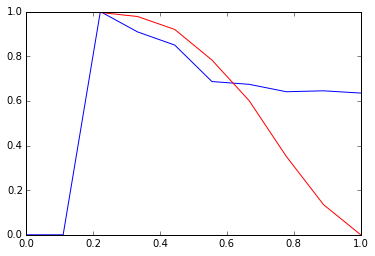

In [86]:
reev_thresh_score, reev_thresh_thrown = zip(*[reeval_ecc_thresh(triplet_eval_1k_allcurv, thresh) 
                                              for thresh in np.linspace(0,1,10)])
plt.plot(np.linspace(0,1,10), reev_thresh_score, color='b')
plt.plot(np.linspace(0,1,10), reev_thresh_thrown, color='r')

0.157423564593
True


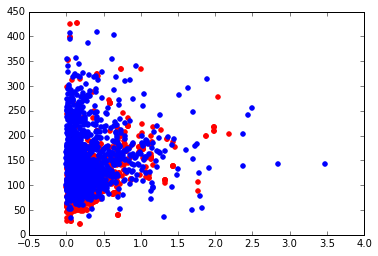

In [101]:
# Measuring explicit skew between two sets of left right notch points
# Assumptions: on the x-axis, it's always in order: left, notch, right
# On the y-axis, no assumption on position (the fluke is deformable more in the y-axis)

# We first take 1- the ratio of the signed distance between left and notch, notch and right for each axis
# then we compute x-skew as the ratio between these distances, and y-skew the same
# The total "skew" is then just the euclidean distance between these measures for each image

def manual_skew(points):
    # assume points are in order left right notch
    # 1 - ratio of dist from left to notch to dist from notch to right
    # so ideally we want a equidistant left notch right ordering in X
    # and both left and right to be above notch by the same amount in y
    # a perfect set of points should have skew (0,0), so the ratios should be 1
    horiz = (1 - (points[0][0] - points[2][0]) / (points[2][0] - points[1][0]))
    vert = (1 - (points[2][0] - points[0][0]) / (points[2][0] - points[1][0])) # y increases as we go down
    return np.array((horiz, vert))

def distance_manual_skew_correlation(evaluation):
    distances = []
    manual_skew_dists = []
    for triplet_info in evaluation:
        distances.append(triplet_info['anchor_pos_dist'])
        distances.append(triplet_info['anchor_neg_dist'])
        skew_anchor = manual_skew(img_points_map[triplet_info['anchor_fn']])
        skew_pos = manual_skew(img_points_map[triplet_info['pos_fn']])
        skew_neg = manual_skew(img_points_map[triplet_info['neg_fn']])
        manual_skew_dists.append(np.linalg.norm(skew_anchor - skew_pos))
        manual_skew_dists.append(np.linalg.norm(skew_anchor - skew_neg))
        
    
    correlation = np.corrcoef(distances, manual_skew_dists)[0,1]
    significance = (correlation*np.sqrt((len(distances)-2) / (1-correlation**2))) > 2
    plt.scatter(manual_skew_dists[::2], distances[::2], color='r') # pos
    plt.scatter(manual_skew_dists[1::2], distances[1::2], color='b') # neg

    print(correlation)
    print(significance)
    
distance_manual_skew_correlation(triplet_eval_1k)

0.63631701575
True


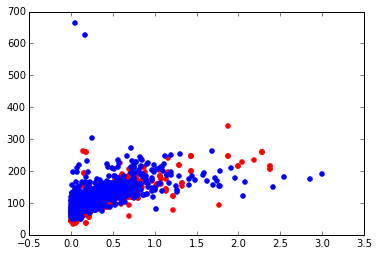

In [103]:
distance_manual_skew_correlation(triplet_eval_1k_allcurv)

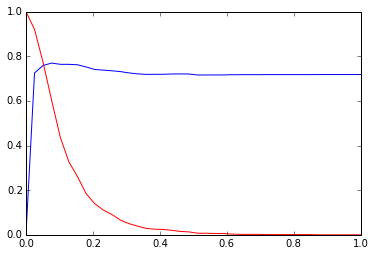

In [107]:
def reeval_manual_skew(evaluation, thresh=2):
    thrown = 0
    good = 0
    bad = 0
    for triplet_info in evaluation:
        skew_anchor = manual_skew(img_points_map[triplet_info['anchor_fn']])
        skew_pos = manual_skew(img_points_map[triplet_info['pos_fn']])
        skew_neg = manual_skew(img_points_map[triplet_info['neg_fn']])
        
        skewdist_anchor_pos = np.linalg.norm(skew_anchor - skew_pos)
        skewdist_anchor_neg = np.linalg.norm(skew_anchor - skew_neg)
        
        if skewdist_anchor_pos > thresh or skewdist_anchor_neg > thresh:
            thrown += 1
            continue
        elif triplet_info['anchor_pos_dist'] < triplet_info['anchor_neg_dist']:
            good += 1
        else:
            bad += 1
    return (good / float(good + bad + 1e-7)), thrown / float(len(evaluation))
reev_thresh_score, reev_thresh_thrown = zip(*[reeval_manual_skew(triplet_eval_1k, thresh) 
                                              for thresh in np.linspace(0,4,40)])
plt.plot(np.linspace(0,1,40), reev_thresh_score, color='b')
plt.plot(np.linspace(0,1,40), reev_thresh_thrown, color='r')

In [ ]:
# Path smoothness: get the curvature 